# Creating training and testing data for segmentation


In [1]:
import napari
from macrohet import dataio, tile
import btrack
import os
from tqdm.auto import tqdm
from skimage.io import imread, imsave
import numpy as np

### Use cellpose to bootstrap segmentation maps

In [6]:
from cellpose import models, core

# This checks to see if you have set up your GPU properly.
# CPU performance is a lot slower, but not a problem if you 
# are only processing a few images.
use_GPU = core.use_gpu()
print('>>> GPU activated? %d'%use_GPU)

>>> GPU activated? 1


### Load experiment of choice

The Opera Phenix is a high-throughput confocal microscope that acquires very large 5-dimensional (TCZXY) images over several fields of view in any one experiment. Therefore, a lazy-loading approach is chosen to mosaic, view and annotate these images. This approach depends upon Dask and DaskFusion. The first step is to load the main metadata file (typically called `Index.idx.xml` and located in the main `Images` directory) that contains the image filenames and associated TCXZY information used to organise the images.

In [2]:
base_dir = '/mnt/DATA/macrohet/'
# base_dir = '/Volumes/lab-gutierrezm/home/users/dayn/macrohet_nemo/'
metadata_fn = os.path.join(base_dir, 'macrohet_images/Index.idx.xml')
metadata = dataio.read_harmony_metadata(metadata_fn)  
metadata

Reading metadata XML file...


Extracting HarmonyV5 metadata:   0%|          | 0/113400 [00:00<?, ?it/s]

Extracting metadata complete!


,id,State,URL,Row,Col,FieldID,PlaneID,TimepointID,ChannelID,FlimID,...,PositionZ,AbsPositionZ,MeasurementTimeOffset,AbsTime,MainExcitationWavelength,MainEmissionWavelength,ObjectiveMagnification,ObjectiveNA,ExposureTime,OrientationMatrix
0,0303K1F1P1R1,Ok,r03c03f01p01-ch1sk1fk1fl1.tiff,3,3,1,1,0,1,1,...,0,0.135583505,0,2021-04-16T19:09:33.84+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
1,0303K1F1P1R2,Ok,r03c03f01p01-ch2sk1fk1fl1.tiff,3,3,1,1,0,2,1,...,0,0.135583505,0,2021-04-16T19:09:33.84+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
2,0303K1F1P2R1,Ok,r03c03f01p02-ch1sk1fk1fl1.tiff,3,3,1,2,0,1,1,...,2E-06,0.135585502,0,2021-04-16T19:09:34.12+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
3,0303K1F1P2R2,Ok,r03c03f01p02-ch2sk1fk1fl1.tiff,3,3,1,2,0,2,1,...,2E-06,0.135585502,0,2021-04-16T19:09:34.12+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
4,0303K1F1P3R1,Ok,r03c03f01p03-ch1sk1fk1fl1.tiff,3,3,1,3,0,1,1,...,4E-06,0.135587499,0,2021-04-16T19:09:34.4+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113395,0609K75F9P1R2,Ok,r06c09f09p01-ch2sk75fk1fl1.tiff,6,9,9,1,74,2,1,...,0,0.135533601,266399.61,2021-04-19T21:14:19.477+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
113396,0609K75F9P2R1,Ok,r06c09f09p02-ch1sk75fk1fl1.tiff,6,9,9,2,74,1,1,...,2E-06,0.135535598,266399.61,2021-04-19T21:14:19.757+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
113397,0609K75F9P2R2,Ok,r06c09f09p02-ch2sk75fk1fl1.tiff,6,9,9,2,74,2,1,...,2E-06,0.135535598,266399.61,2021-04-19T21:14:19.757+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
113398,0609K75F9P3R1,Ok,r06c09f09p03-ch1sk75fk1fl1.tiff,6,9,9,3,74,1,1,...,4E-06,0.135537595,266399.61,2021-04-19T21:14:20.037+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."


### View assay layout and mask information (optional)

The Opera Phenix acquires many time lapse series from a range of positions. The first step is to inspect the image metadata, presented in the form of an `Assaylayout/experiment_ID.xml` file, to show which positions correspond to which experimental assays.

In [3]:
metadata_path = os.path.join(base_dir, 'macrohet_images/Assaylayout/20210602_Live_cell_IPSDMGFP_ATB.xml')
assay_layout = dataio.read_harmony_metadata(metadata_path, assay_layout=True,)# mask_exist=True,  image_dir = image_dir, image_metadata = metadata)
assay_layout

Reading metadata XML file...
Extracting metadata complete!


Strain Compound Concentration ConcentrationEC
3 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA            60            EC50
  7     WT      RIF           0.1            EC50
  8     WT      INH          0.04            EC50
  9     WT      BDQ          0.02            EC50
4 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA            60            EC50
  7     WT      RIF           0.1            EC50
  8     WT      INH          0.04            EC50
  9     WT      BDQ          0.02            EC50
5 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA           400            EC99
  7     WT      RIF             2            EC99
  8     WT      INH             2            EC99
  9     WT      BDQ           2.5            EC99
6 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA           400            EC99
  7     WT      RIF             2            EC99
  8     WT      INH             2            EC99
  9     WT      BDQ           2.5            EC99

### Define row and column of choice

In [4]:
row = 3
column = 4

### Now to lazily mosaic the images using Dask prior to viewing them.

1x (75,2,3) [TCZ] image stack takes approximately 1 minute to stitch together, so only load the one field of view I want.

In [11]:
image_dir = os.path.join(base_dir, 'macrohet_images/Images')
images = tile.compile_mosaic(image_dir, 
                             metadata, 
                             row, column, 
                             set_plane='sum_proj',
                             set_channel=1,
                             set_time = 1,
#                             input_transforms = [input_transforms]
                            ).compute().compute().astype(np.uint16)

### Check previous mask

In [6]:
gt_fn = '/mnt/DATA/macrohet/upstream_development/ground_truth/semantic/gt_sem_r03c04f0*p*1-ch1sk2fk1fl1.tiff'

In [7]:
gt_masks = imread(gt_fn)

In [31]:
images = images[0,0,...]

In [13]:
v = napari.Viewer()

v.add_labels(gt_masks, color={1:'cyan'}, opacity=0.5, blending = 'additive')
v.add_image(images, colormap='green', contrast_limits=[0,8000], blending = 'additive'
#             channel_axis=1,
#             name=["macrophage", "mtb"],
#             colormap=["green",  "magenta"],
#             contrast_limits=[[0,6000], [0,1000]], 
#             visible = True
           )

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


<Image layer 'images' at 0x7f21d76e5070>

### Post editing save out

In [20]:
np.save(gt_fn.replace('.tiff', 'updated.npy'), gt_masks)

In [ ]:
imsave(gt_fn.replace('.tiff', 'updated.tiff'), gt_masks)

### Instance to semantic

In [55]:
instance = imread('/mnt/DATA/macrohet/upstream_development/ground_truth/instance/r03c04f0*p*1-ch1sk1fk1fl1.tiff')

In [56]:
v.add_labels(instance)

<Labels layer 'instance' at 0x7f631df589d0>

In [59]:
images34 = tile.compile_mosaic(image_dir, 
                             metadata, 
                             3, 4, 
                             set_plane='sum_proj',
                             set_channel=1,
                             set_time = 1,
#                             input_transforms = [input_transforms]
                            ).compute().compute()
v.add_image(images34)
            

<Image layer 'images34 [1]' at 0x7f63d025cb80>

In [77]:

# def instance_to_semantic(instance_image):
#     # Get unique labels from the instance image
#     unique_labels = np.unique(instance_image)

#     # Create a blank semantic segmentation map
#     semantic_map = np.zeros_like(instance_image, dtype=np.uint16)

#     # Assign unique labels to the semantic map preserving boundaries
#     for label in tqdm(unique_labels):
#         mask = instance_image == label
#         boundaries = np.logical_and(mask, np.logical_not(np.isin(instance_image, unique_labels[unique_labels != label])))
#         semantic_map += (label * boundaries).astype(np.uint16)

#     return semantic_map

def instance_to_semantic(instance_image):
    """
    Quick function to change instance segmentation map to semantic segmentation
    """
    from skimage.morphology import binary_erosion
    
    # Get unique labels from the instance image
    unique_labels = np.unique(instance_image)

    # Create a blank semantic segmentation map
    semantic_map = np.zeros_like(instance_image, dtype=np.uint8)

    # Assign unique labels to the semantic map preserving boundaries
    for label in tqdm(unique_labels[1:]):
        segment = instance_image == label
        eroded_segment = binary_erosion(segment, footprint = np.ones((5,5)))
        semantic_map[eroded_segment] = 1
        # set background to zero
        semantic_map[instance_image == 0] = 0
        semantic_map = semantic_map.astype('i2')


    return semantic_map

In [92]:
semantic = semantic_map

In [ ]:
semantic = instance_to_semantic(instance)

In [97]:
semantic_map.astype('i1')

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int8)

In [95]:
v.add_labels(semantic_map)

<Labels layer 'semantic_map [1]' at 0x7f6331e5ab50>

In [65]:
semantic = instance_to_semantic(instance)

  0%|          | 0/553 [00:00<?, ?it/s]

In [69]:
v.add_labels(semantic)


<Labels layer 'semantic [1]' at 0x7f63880b0850>

In [99]:
imsave('/mnt/DATA/macrohet/upstream_development/ground_truth/semantic/gt_sem_r03c04f0*p*1-ch1sk1fk1fl1.tiff', semantic_map.astype('i1'))

/tmp/ipykernel_311454/547864020.py:1: UserWarning: /mnt/DATA/macrohet/upstream_development/ground_truth/semantic/gt_sem_r03c04f0*p*1-ch1sk1fk1fl1.tiff is a low contrast image
  imsave('/mnt/DATA/macrohet/upstream_development/ground_truth/semantic/gt_sem_r03c04f0*p*1-ch1sk1fk1fl1.tiff', semantic_map.astype('i1'))


In [98]:
np.save('/mnt/DATA/macrohet/upstream_development/ground_truth/npy/gt_sem_r03c04f0*p*1-ch1sk1fk1fl1.npy', semantic_map.astype('i1'))

### Saving out raw image counterpart to GT

In [60]:
imsave('/mnt/DATA/macrohet/upstream_development/ground_truth/r06c09f0*p*1-ch1sk1fk1fl1.tiff', gfp_t0)

/tmp/ipykernel_311454/896382558.py:1: UserWarning: /mnt/DATA/macrohet/upstream_development/ground_truth/r06c09f0*p*1-ch1sk1fk1fl1.tiff is a low contrast image
  imsave('/mnt/DATA/macrohet/upstream_development/ground_truth/r06c09f0*p*1-ch1sk1fk1fl1.tiff', gfp_t0)


In [61]:
imsave('/mnt/DATA/macrohet/upstream_development/ground_truth/r03c04f0*p*1-ch1sk1fk1fl1.tiff', images34)

/tmp/ipykernel_311454/43105871.py:1: UserWarning: /mnt/DATA/macrohet/upstream_development/ground_truth/r03c04f0*p*1-ch1sk1fk1fl1.tiff is a low contrast image
  imsave('/mnt/DATA/macrohet/upstream_development/ground_truth/r03c04f0*p*1-ch1sk1fk1fl1.tiff', images34)


# Trial segmentation

In [21]:
from cellpose.models import MODEL_NAMES

MODEL_NAMES

['cyto',
 'nuclei',
 'tissuenet',
 'livecell',
 'cyto2',
 'general',
 'CP',
 'CPx',
 'TN1',
 'TN2',
 'TN3',
 'LC1',
 'LC2',
 'LC3',
 'LC4']

In [22]:
model_name = 'cyto'
model = models.CellposeModel(gpu=use_GPU, model_type=model_name)

In [41]:
diameter_range = np.linspace(50, 500, 10)

In [49]:
mask_diam_dict = dict()
for diameter in tqdm(diameter_range):
    masks, flows, diams = model.eval(gfp_t0, 
                                     diameter=diameter, 
                                     channels=[0,0],
                                     flow_threshold=0.4, 
                                     do_3D=False)
    mask_diam_dict[diameter] = masks

  0%|          | 0/10 [00:00<?, ?it/s]

### Do over whole stack

In [31]:
gfp = images[:,0,...]

In [39]:
def segment(input_frame, diameter):
    
    masks, flows, diams = model.eval(input_frame, 
                                     diameter=diameter, 
                                     channels=[0,0],
                                     flow_threshold=0.4, 
                                     do_3D=False)
    return masks

In [45]:
import pickle

In [46]:
output_fn = '/mnt/DATA/macrohet/upstream_development/row6col9_model_seg/mask_diam_dict.pkl'
mask_diam_dict = dict()
for diameter in tqdm(diameter_range):
    mask_stack = np.stack([segment(input_frame, diameter) for input_frame in tqdm(gfp, leave = 0)])
    mask_diam_dict[diameter] = mask_stack
    with open(output_fn, 'wb') as f:
        pickle.dump(mask_diam_dict, f)
#     np.save(output_fn.replace('.pkl', '.npy'), mask_diam_dict)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

OverflowError: serializing a bytes object larger than 4 GiB requires pickle protocol 4 or higher

In [ ]:
from macrohet import notify

In [ ]:
notify.send_sms('6, 9 segmentation diameter trials done')

# Load tracks

In [9]:
with btrack.io.HDF5FileHandler(os.path.join(f'/mnt/DATA/macrohet/labels/relocalisation/infect_label_{3,5}.h5'), 
                                       'r', 
                                       obj_type='obj_type_1'
                                       ) as reader:
        tracks = reader.tracks
        segmentation = reader.segmentation

napari_tracks, properties, graph = btrack.utils.tracks_to_napari(tracks, ndim=2)

[INFO][2023/05/09 11:35:19 AM] Opening HDF file: /mnt/DATA/macrohet/labels/relocalisation/infect_label_(3, 5).h5...
[INFO][2023/05/09 11:35:19 AM] Loading tracks/obj_type_1
[INFO][2023/05/09 11:35:19 AM] Loading LBEP/obj_type_1
[INFO][2023/05/09 11:35:19 AM] Loading objects/obj_type_1 (28787, 5) (28787 filtered: None)
[INFO][2023/05/09 11:35:30 AM] Loading segmentation (75, 6048, 6048)
[INFO][2023/05/09 11:35:30 AM] Closing HDF file: /mnt/DATA/macrohet/labels/relocalisation/infect_label_(3, 5).h5


### Recolour segmentation

In [12]:
col_segmentation = btrack.utils.update_segmentation(segmentation, tracks, scale = (5.04, 5.04) )

# Launch napari image viewer

In [21]:
viewer = napari.Viewer()
viewer.add_image(images, 
                 channel_axis=1,
                 name=["macrophage", "mtb"],
                 colormap=["green",  "magenta"],
                 contrast_limits=[[0,6000], [0,1000]], 
                 visible = True
                 )
segmentation_layer = viewer.add_labels(segmentation,
                              
#                   scale=(5.04, 5.04,))
                  #color='yellow'
                 )
tracker_layer = viewer.add_tracks(napari_tracks,
#                     properties=properties, 
#                     graph=graph, 
#                     name="Tracks [5,4]", 
                    blending="translucent",
                    visible=True,
                    scale = (1,5.04,5.04)
                )
tracker_layer = viewer.add_tracks(old_napari_tracks,
#                     properties=properties, 
#                     graph=graph, 
#                     name="Tracks [5,4]", 
                    blending="translucent",
                    visible=True,
                    scale = (1,5.04,5.04)
                )

/home/dayn/analysis/btrack/btrack/dataio.py:3: UserWarning: `btrack.dataio` has been deprecated. Please use `btrack.io` subpackage instead.
  warnings.warn(  # noqa: B028


Assistant skips harvesting pyclesperanto as it's not installed.


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


Rendering frames...


100%|███████████████████████████████████████████████████████████████████| 199/199 [00:32<00:00,  6.19it/s]


In [23]:
import seaborn as sns

In [25]:
sns.histplot(images[0,1,...][0:250])


KeyboardInterrupt



Error in callback <function flush_figures at 0x7fc05e134f70> (for post_execute):


KeyboardInterrupt: 

In [ ]:
from skimage.transform import rescale

In [ ]:
rfp_resized = rescale(images[0,1,...], 1200/6048, anti_aliasing=False)

In [ ]:
sns.histplot(rfp_resized[0:250])

In [45]:
### think i need to add pre- scaled tracks to get key binding to work
from macrohet import visualise

In [46]:
pre_scaled_napari_tracks = visualise.scale_napari_tracks(napari_tracks)

In [48]:
tracker_layer = viewer.add_tracks(pre_scaled_napari_tracks,
#                     properties=properties, 
#                     graph=graph, 
#                     name="Tracks [5,4]", 
                    blending="translucent",
                    visible=True,
#                     scale = (1,5.04,5.04)
                )

In [224]:
output_dir = '/mnt/DATA/macrohet/results/Mtb_thresholding/3,5/bg_rm'
@viewer.bind_key('p', overwrite=True)
def Mtb_pos(event=None):
    ### extract cell ID under cursor
    cell_ID = tracker_layer._get_value(position=viewer.cursor.position)
    ### get time frame
    time = viewer.cursor.position[0]
    try:
        positive_track = [track for track in tracks if track.ID == cell_ID][0]
    except:
        print('Looks like there was no identifiable track there')
    ### get index of cell instance of selected frame
    cell_index = positive_track.t.index(time)
    ### extract the pixel intensity of that segment (mean intensity is now for both channels hence last index)
    px_int =  positive_track['mean_intensity'][cell_index][1]
    area = positive_track['area'][cell_index]
    # print to check
    print(cell_ID, px_int)
    ### write to output file
    with open(os.path.join(output_dir, "Mtb_positive.csv"),"a") as f:
        f.write(f"{px_int}\n")
    with open(os.path.join(output_dir, "Mtb_positive_details.csv"),"a") as f:
        f.write(f"{cell_ID, time, px_int, area}\n")
@viewer.bind_key('n', overwrite=True)
def Mtb_neg(event=None):
    ### extract cell ID under cursor
    cell_ID = tracker_layer._get_value(position=viewer.cursor.position)
    ### get time frame
    time = viewer.cursor.position[0]
    try:
        negative_track = [track for track in tracks if track.ID == cell_ID][0]
    except:
        print('Looks like there was no identifiable track there')
    ### get index of cell instance of selected frame
    cell_index = negative_track.t.index(time)
    ### extract the pixel intensity of that segment
    px_int =  negative_track['mean_intensity'][cell_index][1]
    area = negative_track['area'][cell_index]
    # print to check
    print(cell_ID, px_int)
    ### write to output file
    with open(os.path.join(output_dir, "Mtb_negative.csv"),"a") as f:
        f.write(f"{px_int}\n")
    with open(os.path.join(output_dir, "Mtb_negative_details.csv"),"a") as f:
        f.write(f"{cell_ID, time, px_int, area}\n")

# comparing sc fluroescent signals

In [50]:
cell_361 = [cell for cell in tracks if cell.ID ==361][0]
cell_112 = [cell for cell in tracks if cell.ID ==112][0]

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

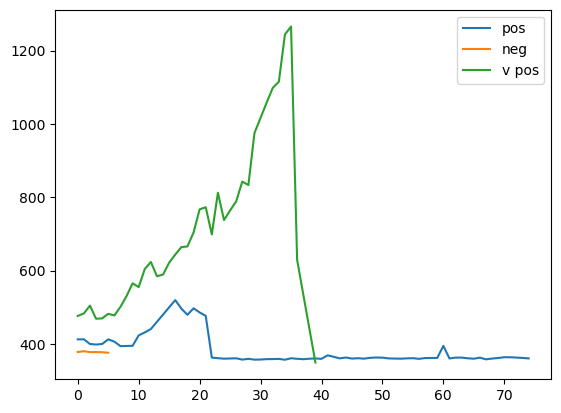

In [51]:
sns.lineplot(data = cell_361['mean_intensity'][:,1], label = 'pos')
sns.lineplot(data = cell_319['mean_intensity'][:,1], label = 'neg')
sns.lineplot(data = cell_112['mean_intensity'][:,1], label = 'v pos')

plt.legend()

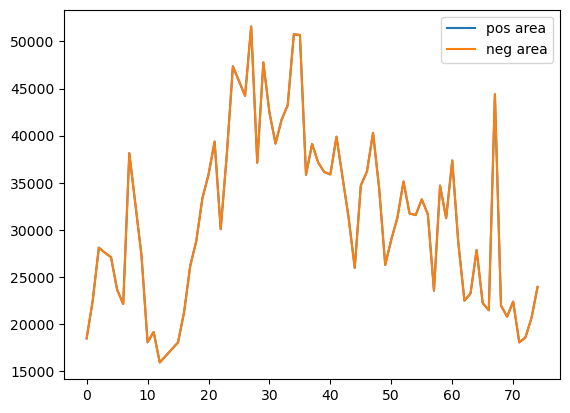

In [49]:
sns.lineplot(data = cell_361['area'], label = 'pos area')
sns.lineplot(data = cell_361['area'], label = 'neg area')

plt.legend()

# Assessing manual thresholding

In [14]:
import pandas as pd

# Load positive values CSV file into a pandas dataframe
df_pos = pd.read_csv('/mnt/DATA/macrohet/results/Mtb_thresholding/3,5/standard/Mtb_positive.csv', header=None, names=['Mean Pixel Value'])
# Add a new column 'label' with value 'positive'
df_pos['label'] = 'positive'

# Load negative values CSV file into a pandas dataframe
df_neg = pd.read_csv('/mnt/DATA/macrohet/results/Mtb_thresholding/3,5/standard/Mtb_negative.csv', header=None, names=['Mean Pixel Value'])
# Add a new column 'label' with value 'negative'
df_neg['label'] = 'negative'

# Concatenate the positive and negative dataframes vertically
df = pd.concat([df_pos, df_neg], axis=0)

# Reset the index of the merged dataframe
df.reset_index(drop=True, inplace=True)


In [15]:
df

,Mean Pixel Value,label
0,376.936859,positive
1,412.553833,positive
2,378.703796,positive
3,384.623138,positive
4,366.230682,positive
...,...,...
419,370.857178,negative
420,358.679199,negative
421,374.481873,negative
422,377.519257,negative


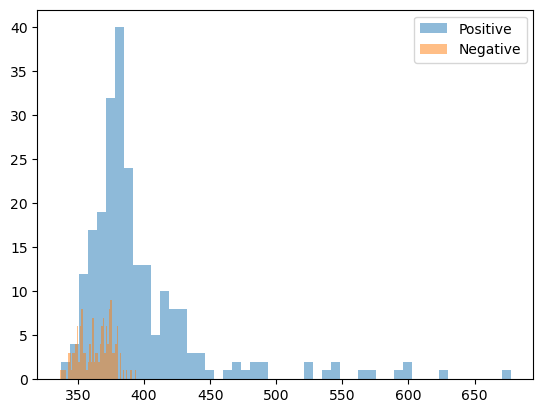

In [49]:
import matplotlib.pyplot as plt

# Separate the positive and negative values into separate dataframes
df_pos = df[df['label'] == 'positive']
df_neg = df[df['label'] == 'negative']

# Plot the histograms
plt.hist(df_pos['Mean Pixel Value'], bins=50, alpha=0.5, label='Positive')
plt.hist(df_neg['Mean Pixel Value'], bins=50, alpha=0.5, label='Negative')
plt.legend(loc='upper right')
plt.show()

### Assessing threshold of total Mtb

In [18]:
import pandas as pd

# Load positive values CSV file into a pandas dataframe
df_pos = pd.read_csv('/mnt/DATA/macrohet/results/Mtb_thresholding/3,5/standard/Mtb_positive_details.csv', header=None, names=['Cell ID', 'Time', 'Mean Pixel Value', 'Area'])
# Add a new column 'label' with value 'positive'
df_pos['label'] = 'positive'

# Load negative values CSV file into a pandas dataframe
df_neg = pd.read_csv('/mnt/DATA/macrohet/results/Mtb_thresholding/3,5/standard/
                     Mtb_negative_details.csv', header=None, names=['Cell ID', 'Time', 'Mean Pixel Value', 'Area'])
# Add a new column 'label' with value 'negative'
df_neg['label'] = 'negative'

# Concatenate the positive and negative dataframes vertically
df = pd.concat([df_pos, df_neg], axis=0)

# Reset the index of the merged dataframe
df.reset_index(drop=True, inplace=True)
# df = df.replace(to_replace=['(', ')'], value='', regex=True)
df['Cell ID'] = df['Cell ID'].str.replace(r'[()]', '')
df['Area'] = df['Area'].str.replace(r'[()]', '')
df = df.drop_duplicates(subset=['Cell ID'])
# Convert the columns to the appropriate numeric type
df['Mean Pixel Value'] = df['Mean Pixel Value'].astype(float)
df['Area'] = df['Area'].astype(float)

# Add a new column for the summed pixel intensity
df['Summed intensity'] = df['Mean Pixel Value'] * df['Area']


/tmp/ipykernel_12245/2917147011.py:19: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Cell ID'] = df['Cell ID'].str.replace(r'[()]', '')
/tmp/ipykernel_12245/2917147011.py:20: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Area'] = df['Area'].str.replace(r'[()]', '')


In [19]:
df

,Cell ID,Time,Mean Pixel Value,Area,label,Summed intensity
0,310,0.0,376.936859,28036.0,positive,1.056780e+07
1,361,0.0,412.553833,18479.0,positive,7.623582e+06
2,346,0.0,378.703796,76096.0,positive,2.881784e+07
3,272,0.0,384.623138,57299.0,positive,2.203852e+07
4,273,0.0,366.230682,14726.0,positive,5.393113e+06
...,...,...,...,...,...,...
419,209,0.0,370.857180,25633.0,negative,9.506182e+06
420,192,0.0,358.679199,77104.0,negative,2.765560e+07
421,168,0.0,374.481873,21249.0,negative,7.957365e+06
422,236,0.0,377.519257,82198.0,negative,3.103133e+07


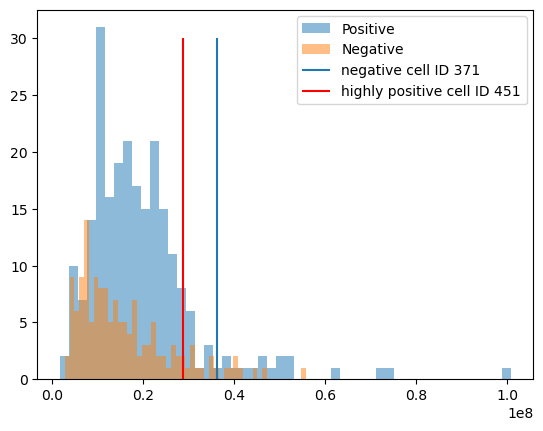

In [22]:
import matplotlib.pyplot as plt

# Separate the positive and negative values into separate dataframes
df_pos = df[df['label'] == 'positive']
df_neg = df[df['label'] == 'negative']
# Plot the histograms
plt.hist(df_pos['Summed intensity'], bins=50, alpha=0.5, label='Positive')
plt.hist(df_neg['Summed intensity'], bins=50, alpha=0.5, label='Negative')
plt.vlines(36284242, ymin = 0, ymax = 30, label = 'negative cell ID 371')
plt.vlines(28788085.73953247, ymin = 0, ymax = 30, label = 'highly positive cell ID 451', color = 'red')
plt.legend(loc='upper right')
plt.show()

# WTF

These should not be overlapping at all!

In [122]:
print('Area, mean int', [track for track in tracks if track.ID == 451][0]['area'][0], [track for track in tracks if track.ID == 451][0]['mean_intensity'][0])
print('sum int', [track for track in tracks if track.ID == 451][0]['area'][0]*[track for track in tracks if track.ID == 451][0]['mean_intensity'][0][-1])

Area, mean int 80081.0 [1890.44628906  359.48709106]
sum int 28788085.73953247


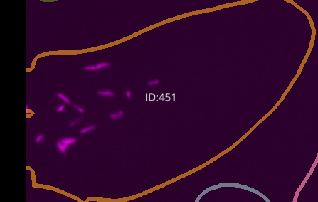

In [123]:
print('Area, mean int', [track for track in tracks if track.ID == 371][0]['area'][0], [track for track in tracks if track.ID == 371][0]['mean_intensity'][0])
print('sum int', [track for track in tracks if track.ID == 371][0]['area'][0]*[track for track in tracks if track.ID == 371][0]['mean_intensity'][0][-1])

Area, mean int 102737.0 [1222.06115723  353.17599487]
sum int 36284242.18527222


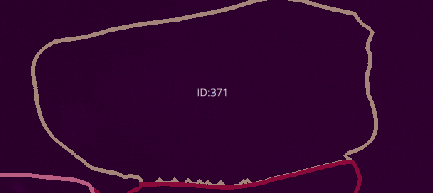

# Isolating a single cell image

In [23]:
rfp_t0 = images[0,1,...]

In [24]:
seg_t0 = segmentation[0]

In [25]:
### segment for 451 has pixel value 125
segment_451 = seg_t0 == 125

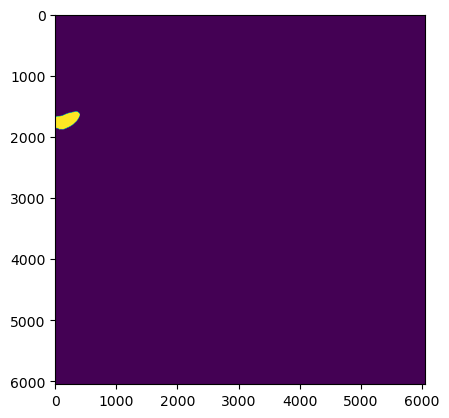

In [26]:
plt.imshow(segment_451)

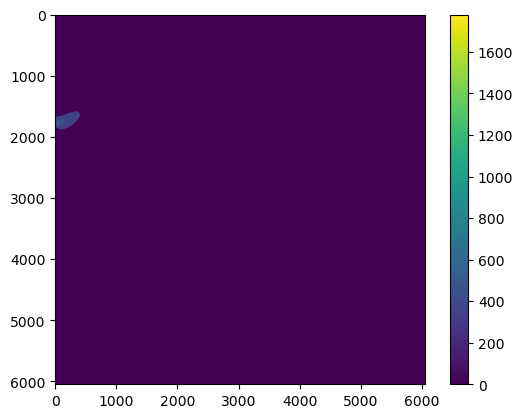

In [27]:
plt.imshow(rfp_t0*segment_451)
plt.colorbar()

In [30]:
import numpy as np

In [31]:
np.sum(rfp_t0*segment_451)

28788086

In [32]:
print('sum int', [track for track in tracks if track.ID == 451][0]['area'][0]*[track for track in tracks if track.ID == 451][0]['mean_intensity'][0][-1])

sum int 28788085.73953247


# Now for negative cell 371

In [33]:
### segment for 371 has pixel value 205
segment_371 = seg_t0 == 205

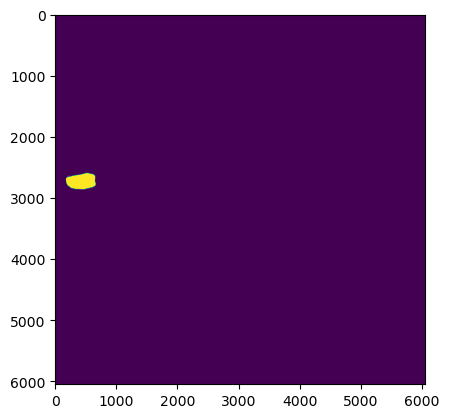

In [34]:
plt.imshow(segment_371)

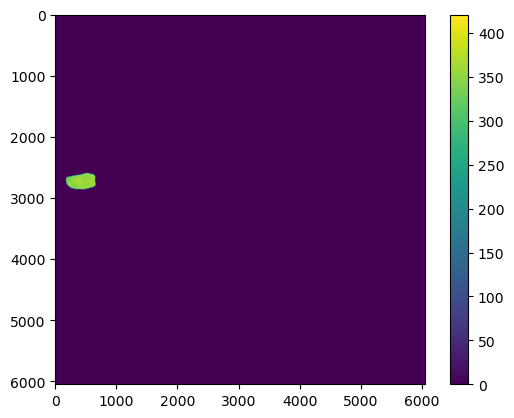

In [35]:
plt.imshow(rfp_t0*segment_371)
plt.colorbar()

In [36]:
np.sum(rfp_t0*segment_371)

36284243

In [37]:
print('sum int', [track for track in tracks if track.ID == 371][0]['area'][0]*[track for track in tracks if track.ID == 371][0]['mean_intensity'][0][-1])

sum int 36284242.18527222


# The localisation step works correctly, 

It correctly extracts the pixel values from the ROI

# Is it the fact that my images are being loaded as 64 bit? - no

In [157]:
rfp_t0_16bit = tile.compile_mosaic(image_dir, 
                             metadata, 
                             row, column, 
                             set_plane='sum_proj',
                             set_channel=2,
                             set_time = 0,
#                             input_transforms = [input_transforms]
                            ).compute().compute().astype(np.uint16)[0,0,...]

In [162]:
rfp_t0_16bit.dtype

dtype('uint16')

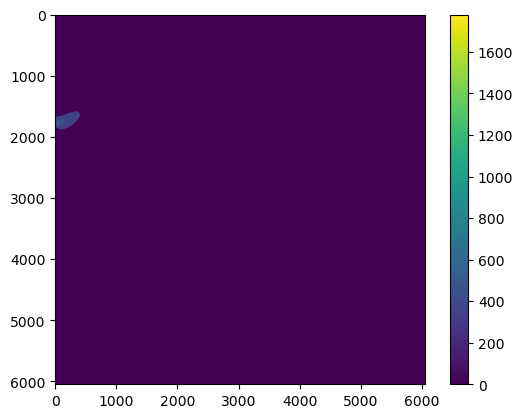

In [158]:
plt.imshow(rfp_t0_16bit*segment_451)
plt.colorbar()

In [160]:
np.sum(rfp_t0_16bit*segment_451)

28788086

In [161]:
print('sum int', [track for track in tracks if track.ID == 451][0]['area'][0]*[track for track in tracks if track.ID == 451][0]['mean_intensity'][0][-1])

sum int 28788085.73953247


# Now for negative cell 371

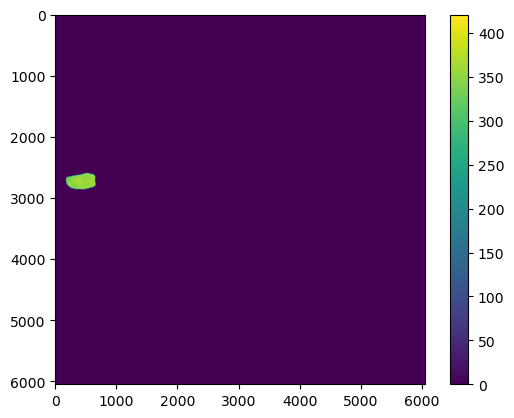

In [163]:
plt.imshow(rfp_t0_16bit*segment_371)
plt.colorbar()

In [164]:
np.sum(rfp_t0_16bit*segment_371)

36284243

In [165]:
print('sum int', [track for track in tracks if track.ID == 371][0]['area'][0]*[track for track in tracks if track.ID == 371][0]['mean_intensity'][0][-1])

sum int 36284242.18527222


# What if I subtract a background

# octolite

In [39]:
from octopuslite import utils

In [40]:
bg = utils.estimate_background(rfp_t0)

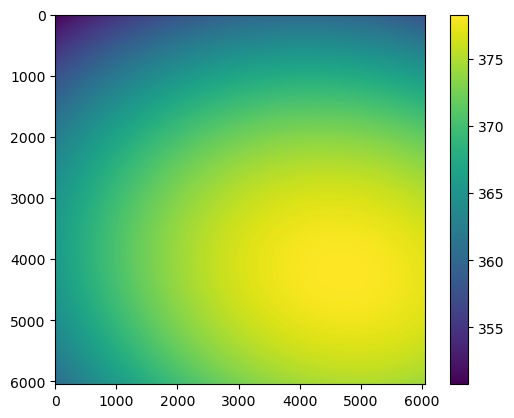

In [41]:
plt.imshow(bg)
plt.colorbar()

In [43]:
corrected = utils.remove_background(rfp_t0)

In [50]:
viewer.add_image(corrected)

<Image layer 'corrected' at 0x7feedd57b490>

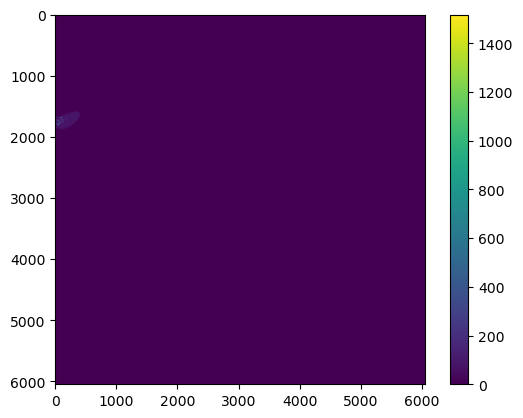

In [184]:
plt.imshow(corrected*segment_451)
plt.colorbar()

In [193]:
np.sum(corrected*segment_451)

7752402.0

In [194]:
np.sum(corrected*segment_451)/np.sum(segment_451)

96.8070079044967

# Now for negative cell 371

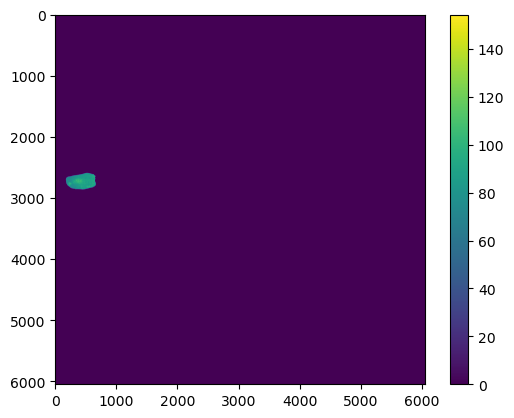

In [187]:
plt.imshow(corrected*segment_371)
plt.colorbar()

In [195]:
np.sum(corrected*segment_371)

8861011.0

In [196]:
np.sum(corrected*segment_371)/np.sum(segment_371)

86.24946221906421

# % difference between positive and negative?

In [200]:
(np.sum(corrected*segment_451)/np.sum(segment_451) - np.sum(corrected*segment_371)/np.sum(segment_371))/(np.sum(corrected*segment_451)/np.sum(segment_451))*100


10.905765929516026

# Conclusion:

The uneven background illumination means that Mtb positive cells in darker regions of the image may even result in lower mean and summed pixel value measurements. In order to circumvent this, a background removal must be conducted on images before the localisation step.

In [207]:
input_transforms = utils.remove_background
test_image = tile.compile_mosaic(image_dir, 
                             metadata, 
                             row, column, 
                             set_plane='sum_proj',
                             set_channel=2,
                             set_time = 0,
                            input_transforms = [input_transforms]
                            ).compute().compute().astype(np.uint16)[0,0,...]

In [209]:
viewer.add_image(test_image)

<Image layer 'test_image' at 0x7f7de1981a60>

In [210]:
images = tile.compile_mosaic(image_dir, 
                                 metadata, 
                                 row, 
                                 column, 
                                 set_plane = 'sum_proj',
                                 set_time = 0,
                                 input_transforms = [input_transforms]
                                 ).astype(np.uint16)

In [213]:
test_image_2 = images.compute().compute()

In [215]:
test_image_2.shape

(1, 2, 6048, 6048)

In [214]:
viewer.add_image(test_image_2)

<Image layer 'test_image_2' at 0x7f7df7d0f5e0>

# Reloading tracks

In [52]:
with btrack.io.HDF5FileHandler(os.path.join(base_dir, f'labels/relocalisation/relocalised_bg_rm_{row, column}.h5'), 
                                       'r', 
                                       obj_type='obj_type_1'
                                       ) as reader:
        tracks_bgrm = reader.tracks    
        segmentation = reader.segmentation
napari_tracks_bgrm, properties, graph = btrack.utils.tracks_to_napari(tracks, ndim=2)

[INFO][2023/05/03 12:22:05 pm] Opening HDF file: /mnt/DATA/macrohet/labels/relocalisation/relocalised_bg_rm_(3, 5).h5...
03-May-23 12:22:05 - btrack.io.hdf - INFO     - Opening HDF file: /mnt/DATA/macrohet/labels/relocalisation/relocalised_bg_rm_(3, 5).h5...
[INFO][2023/05/03 12:22:05 pm] Loading tracks/obj_type_1
03-May-23 12:22:05 - btrack.io.hdf - INFO     - Loading tracks/obj_type_1
[INFO][2023/05/03 12:22:05 pm] Loading LBEP/obj_type_1
03-May-23 12:22:05 - btrack.io.hdf - INFO     - Loading LBEP/obj_type_1
[INFO][2023/05/03 12:22:05 pm] Loading objects/obj_type_1 (28764, 5) (28764 filtered: None)
03-May-23 12:22:05 - btrack.io.hdf - INFO     - Loading objects/obj_type_1 (28764, 5) (28764 filtered: None)
[INFO][2023/05/03 12:22:14 pm] Loading segmentation (75, 6048, 6048)
03-May-23 12:22:14 - btrack.io.hdf - INFO     - Loading segmentation (75, 6048, 6048)
[INFO][2023/05/03 12:22:14 pm] Closing HDF file: /mnt/DATA/macrohet/labels/relocalisation/relocalised_bg_rm_(3, 5).h5
03-May-23

In [53]:
tracks_bgrm[0]

,ID,t,x,y,z,parent,root,state,generation,dummy,mean_intensity,major_axis_length,area,orientation,minor_axis_length
0,317,0,1067.368652,55.120907,0.000000,317,317,5,0,False,"(2,) array",367.548309,79792.0,0.543640,297.442078
1,317,1,1076.627319,53.511284,0.000000,317,317,5,0,False,"(2,) array",343.924652,59611.0,0.830746,233.694473
2,317,2,1086.090088,46.542519,0.000000,317,317,5,0,False,"(2,) array",321.399139,60298.0,1.330036,241.751312
3,317,3,1067.435425,41.517868,0.000000,317,317,5,0,False,"(2,) array",339.685303,59265.0,1.387981,224.850403
4,317,4,1049.771729,38.330784,0.000000,317,317,5,0,False,"(2,) array",411.977295,63411.0,1.566783,203.218185
5,317,5,1050.415771,41.688465,0.000000,317,317,5,0,False,"(2,) array",543.717041,89396.0,-1.518311,222.127838
6,317,6,1034.244141,41.081558,0.000000,317,317,5,0,False,"(2,) array",449.364075,67568.0,-1.358899,200.842819
7,317,7,1025.088135,37.680584,-3.657916,317,317,5,0,True,"(2,) array",NaN,NaN,NaN,NaN
8,317,8,1032.142212,40.969135,0.000000,317,317,5,0,False,"(2,) array",464.707703,71756.0,-1.217776,211.361130
9,317,9,1060.545654,41.469288,0.000000,317,317,5,0,False,"(2,) array",647.624390,94893.0,-1.538676,207.644241


### Pre bg rm

In [122]:
print('Area, mean int', [track for track in tracks if track.ID == 451][0]['area'][0], [track for track in tracks if track.ID == 451][0]['mean_intensity'][0])
print('sum int', [track for track in tracks if track.ID == 451][0]['area'][0]*[track for track in tracks if track.ID == 451][0]['mean_intensity'][0][-1])

Area, mean int 80081.0 [1890.44628906  359.48709106]
sum int 28788085.73953247


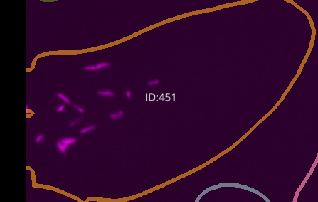

In [123]:
print('Area, mean int', [track for track in tracks if track.ID == 371][0]['area'][0], [track for track in tracks if track.ID == 371][0]['mean_intensity'][0])
print('sum int', [track for track in tracks if track.ID == 371][0]['area'][0]*[track for track in tracks if track.ID == 371][0]['mean_intensity'][0][-1])

Area, mean int 102737.0 [1222.06115723  353.17599487]
sum int 36284242.18527222


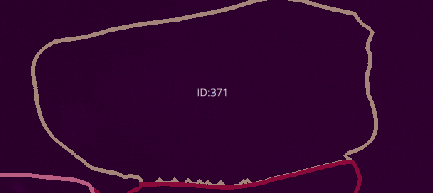

### Post bg rm

In [222]:
print('Area, mean int', [track for track in tracks_bgrm if track.ID == 451][0]['area'][0], [track for track in tracks_bgrm if track.ID == 451][0]['mean_intensity'][0])
print('sum int', [track for track in tracks_bgrm if track.ID == 451][0]['area'][0]*[track for track in tracks_bgrm if track.ID == 451][0]['mean_intensity'][0][-1])

Area, mean int 80081.0 [1922.62353516  116.66760254]
sum int 9342858.278930664


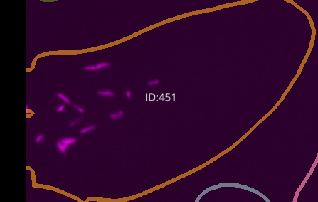

In [223]:
print('Area, mean int', [track for track in tracks_bgrm if track.ID == 371][0]['area'][0], [track for track in tracks_bgrm if track.ID == 371][0]['mean_intensity'][0])
print('sum int', [track for track in tracks_bgrm if track.ID == 371][0]['area'][0]*[track for track in tracks_bgrm if track.ID == 371][0]['mean_intensity'][0][-1])

Area, mean int 102737.0 [1411.3013916    96.26482391]
sum int 9889959.214408875


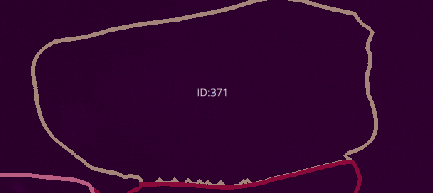

In [145]:
output_dir = '/mnt/DATA/macrohet/results/Mtb_thresholding/3,5/bg_rm'
@viewer.bind_key('p', overwrite=True)
def Mtb_pos(event=None):
    ### extract cell ID under cursor
    cell_ID = tracker_layer._get_value(position=viewer.cursor.position)
    ### get time frame
    time = viewer.cursor.position[0]
    try:
        positive_track = [track for track in tracks if track.ID == cell_ID][0]
    except:
        print('Looks like there was no identifiable track there')
    ### get index of cell instance of selected frame
    cell_index = positive_track.t.index(time)
    ### extract the pixel intensity of that segment (mean intensity is now for both channels hence last index)
    px_int =  positive_track['mean_intensity'][cell_index][1]
    area = positive_track['area'][cell_index]
    # print to check
    print(cell_ID, px_int)
    ### write to output file
    with open(os.path.join(output_dir, "Mtb_positive.csv"),"a") as f:
        f.write(f"{px_int}\n")
    with open(os.path.join(output_dir, "Mtb_positive_details.csv"),"a") as f:
        f.write(f"{cell_ID, time, px_int, area}\n")
@viewer.bind_key('n', overwrite=True)
def Mtb_neg(event=None):
    ### extract cell ID under cursor
    cell_ID = tracker_layer._get_value(position=viewer.cursor.position)
    ### get time frame
    time = viewer.cursor.position[0]
    try:
        negative_track = [track for track in tracks if track.ID == cell_ID][0]
    except:
        print('Looks like there was no identifiable track there')
    ### get index of cell instance of selected frame
    cell_index = negative_track.t.index(time)
    ### extract the pixel intensity of that segment
    px_int =  negative_track['mean_intensity'][cell_index][1]
    area = negative_track['area'][cell_index]
    # print to check
    print(cell_ID, px_int)
    ### write to output file
    with open(os.path.join(output_dir, "Mtb_negative.csv"),"a") as f:
        f.write(f"{px_int}\n")
    with open(os.path.join(output_dir, "Mtb_negative_details.csv"),"a") as f:
        f.write(f"{cell_ID, time, px_int, area}\n")

In [230]:
pre_scaled_napari_tracks = visualise.scale_napari_tracks(napari_tracks_bgrm)

In [ ]:
tracker_layer = viewer.add_tracks(pre_scaled_napari_tracks,
#                     properties=properties, 
#                     graph=graph, 
#                     name="Tracks [5,4]", 
                    blending="translucent",
                    visible=True,
#                     scale = (1,5.04,5.04)
                )

323 345.0231018066406
308 350.0428466796875
324 353.2033386230469
351 346.1866
358 369.42923
361 412.5538330078125
310 376.9368591308594
353 380.16956
319 378.03397
339 394.500244140625
341 372.3873596191406
346 378.70379638671875
273 366.2306823730469


# Instead of going through the whole image again, just extract the IDs from previous measures

In [232]:
df

,Cell ID,Time,Mean Pixel Value,Area,label,Summed intensity
0,310,0.0,376.936859,28036.0,positive,1.056780e+07
1,361,0.0,412.553833,18479.0,positive,7.623582e+06
2,346,0.0,378.703796,76096.0,positive,2.881784e+07
3,272,0.0,384.623138,57299.0,positive,2.203852e+07
4,273,0.0,366.230682,14726.0,positive,5.393113e+06
...,...,...,...,...,...,...
419,209,0.0,370.857180,25633.0,negative,9.506182e+06
420,192,0.0,358.679199,77104.0,negative,2.765560e+07
421,168,0.0,374.481873,21249.0,negative,7.957365e+06
422,236,0.0,377.519257,82198.0,negative,3.103133e+07


In [54]:
# Create an empty DataFrame to store the results
result_df = pd.DataFrame(columns=df.columns)

# Iterate over each row in the original DataFrame
for index, row in df.iterrows():
    # Get the cell ID
    cell_ID = int(row['Cell ID'])
    
    # Find the corresponding track in the list of tracks
    track = next((t for t in tracks_bgrm if t.ID == cell_ID), None)
    
    if track is not None:
        # Update the row with the mean pixel value and summed intensity
        row['Mean Pixel Value BG RM'] = track['mean_intensity'][0][1]
        row['Summed intensity BG RM'] = row['Mean Pixel Value BG RM'] * row['Area']
        
        # Append the updated row to the result DataFrame
        result_df = pd.concat([result_df, row.to_frame().T], ignore_index=True)


In [55]:
result_df

,Cell ID,Time,Mean Pixel Value,Area,label,Summed intensity,Mean Pixel Value BG RM,Summed intensity BG RM
0,310,0.0,376.936859,28036.0,positive,10567801.782593,115.802643,3246642.894165
1,361,0.0,412.553833,18479.0,positive,7623582.280151,147.888626,2732833.921677
2,346,0.0,378.703796,76096.0,positive,28817844.089844,113.276688,8619902.821289
3,272,0.0,384.623138,57299.0,positive,22038521.208771,118.797989,6807005.9655
4,273,0.0,366.230682,14726.0,positive,5393113.028625,120.437187,1773558.018631
...,...,...,...,...,...,...,...,...
374,209,0.0,370.85718,25633.0,negative,9506182.09494,121.847305,3123311.9767
375,192,0.0,358.679199,77104.0,negative,27655600.976562,126.883972,9783261.790039
376,168,0.0,374.481873,21249.0,negative,7957365.309998,122.87915,2611059.06665
377,236,0.0,377.519257,82198.0,negative,31031327.853333,121.82766,10013989.964371


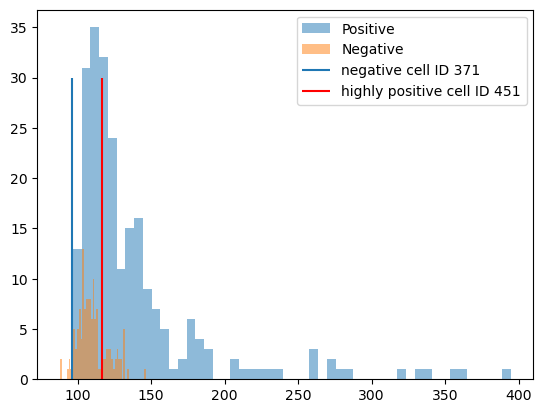

In [56]:
import matplotlib.pyplot as plt

# Separate the positive and negative values into separate dataframes
df_pos = result_df[result_df['label'] == 'positive']
df_neg = result_df[result_df['label'] == 'negative']
# Plot the histograms
plt.hist(df_pos['Mean Pixel Value BG RM'], bins=50, alpha=0.5, label='Positive')
plt.hist(df_neg['Mean Pixel Value BG RM'], bins=50, alpha=0.5, label='Negative')
plt.vlines(96.26482391, ymin = 0, ymax = 30, label = 'negative cell ID 371')
plt.vlines(116.66760254, ymin = 0, ymax = 30, label = 'highly positive cell ID 451', color = 'red')
plt.legend(loc='upper right')
plt.show()

# Seems like the BG removal did some good 

### inspecting individual cells

In [57]:
rfp_t0_bgrm = images[0,1,...]

In [58]:
viewer.add_image(rfp_t0_bgrm)

<Image layer 'rfp_t0_bgrm' at 0x7fee36845c40>

In [59]:
rfp_451 = segment_451*rfp_t0_bgrm

In [60]:
viewer.add_image(rfp_451)

<Image layer 'rfp_451' at 0x7fee36902190>

In [61]:
rfp_371 = segment_371*rfp_t0_bgrm

In [62]:
viewer.add_image(rfp_371)

<Image layer 'rfp_371' at 0x7fee3ab05cd0>

In [63]:
rfp_451_crop = rfp_451[1570:1900, 0:430]

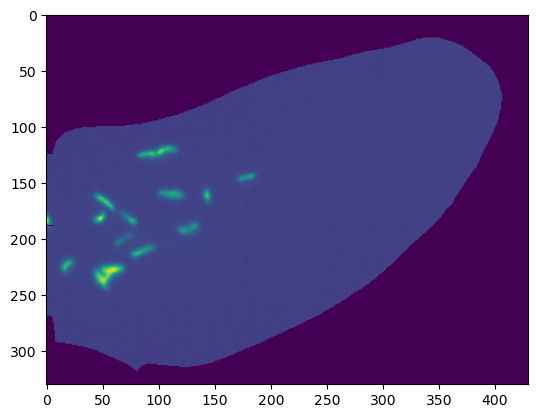

In [64]:
plt.imshow(rfp_451_crop)

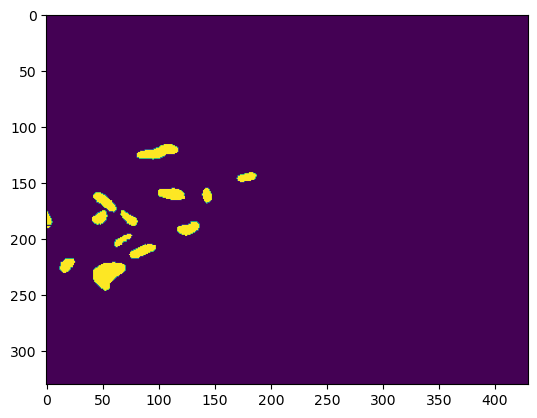

In [147]:
plt.imshow(rfp_451_crop>500)

(array([[187., 110.,  19., ...,   3.,   1.,   3.],
        [187., 115.,  16., ...,   2.,   3.,   0.],
        [187., 115.,  17., ...,   0.,   0.,   0.],
        ...,
        [330.,   0.,   0., ...,   0.,   0.,   0.],
        [330.,   0.,   0., ...,   0.,   0.,   0.],
        [330.,   0.,   0., ...,   0.,   0.,   0.]]),
 array([   0. ,  177.9,  355.8,  533.7,  711.6,  889.5, 1067.4, 1245.3,
        1423.2, 1601.1, 1779. ]),
 <a list of 430 BarContainer objects>)

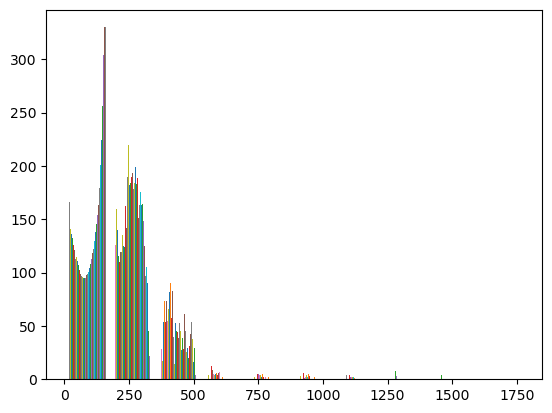

In [148]:
plt.hist(rfp_451_crop)
# plt.xlim(0, 500)

# trying other bg rm

In [71]:
rfp_t0.astype(np.float32)

array([[  0.,   0.,   0., ...,   0.,   0.,   0.],
       [313., 303., 304., ..., 296., 301.,   0.],
       [314., 316., 309., ..., 317., 311.,   0.],
       ...,
       [332., 337., 328., ..., 323., 315.,   0.],
       [335., 342., 318., ..., 325., 320.,   0.],
       [334., 333., 299., ..., 312., 322.,   0.]], dtype=float32)

In [80]:

# Define the kernel
kernel = np.ones((5, 5), np.float32) / 25

# Apply the filter
filtered = cv2.filter2D(rfp_t0.astype(np.float32), -1, kernel)


In [81]:
filtered

array([[247.28   , 250.07999, 251.59998, ..., 200.07999, 197.99997,
        195.99997],
       [248.48   , 250.84   , 252.2    , ..., 200.64   , 198.36   ,
        196.55998],
       [252.12001, 253.68   , 254.31999, ..., 203.68001, 201.84001,
        201.04002],
       ...,
       [336.19995, 332.55994, 328.59995, ..., 260.76   , 258.00003,
        258.48   ],
       [331.84   , 329.91998, 327.00003, ..., 260.48   , 257.     ,
        256.88   ],
       [329.28003, 328.00003, 325.24002, ..., 260.6    , 256.36002,
        256.00003]], dtype=float32)

In [82]:
viewer.add_image(filtered)

<Image layer 'filtered' at 0x7feed0257160>

# Applying a flatfield correction gpt

In [105]:
rfp_t0

array([[  0,   0,   0, ...,   0,   0,   0],
       [313, 303, 304, ..., 296, 301,   0],
       [314, 316, 309, ..., 317, 311,   0],
       ...,
       [332, 337, 328, ..., 323, 315,   0],
       [335, 342, 318, ..., 325, 320,   0],
       [334, 333, 299, ..., 312, 322,   0]], dtype=uint64)

In [120]:
%%time 

# Compute the local minimum of the image using a morphological opening operation
kernel_size = 100# Adjust this parameter based on the size of the features in the image
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
img_min = cv2.erode(rfp_t0.astype(np.uint16), kernel)

# Compute the flat field image by dividing the original image by the local minimum
flat_field = rfp_t0 / (img_min + 1e-6) 

# Normalize the flat field image to have a mean of 1.0
# flat_field /= np.mean(flat_field)

# Divide the image by the flat field image and scale to 0-255 range
corrected = (rfp_t0.astype(np.uint16) / flat_field) 
# corrected = np.clip(corrected, 0, 2**16).astype(np.uint16)

CPU times: user 8.33 s, sys: 132 ms, total: 8.46 s
Wall time: 8.46 s


<timed exec>:13: RuntimeWarning: invalid value encountered in true_divide


In [122]:
flat_field

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.13000000e+08, 3.03000000e+08, 3.04000000e+08, ...,
        2.96000000e+08, 3.01000000e+08, 0.00000000e+00],
       [3.14000000e+08, 3.16000000e+08, 3.09000000e+08, ...,
        3.17000000e+08, 3.11000000e+08, 0.00000000e+00],
       ...,
       [1.13698630e+00, 1.15410959e+00, 1.12328767e+00, ...,
        3.23000000e+08, 3.15000000e+08, 0.00000000e+00],
       [1.14726027e+00, 1.17123287e+00, 1.08904109e+00, ...,
        3.25000000e+08, 3.20000000e+08, 0.00000000e+00],
       [1.14383561e+00, 1.14041095e+00, 1.02397260e+00, ...,
        3.12000000e+08, 3.22000000e+08, 0.00000000e+00]])

In [123]:
viewer.add_image(flat_field)

<Image layer 'flat_field [1]' at 0x7fee7753be80>

In [118]:
viewer.add_image(corrected)

<Image layer 'corrected [1]' at 0x7fee7a0159d0>

# octolite

In [124]:
from octopuslite import utils

In [126]:
octo_bg = utils.estimate_background(rfp_t0)

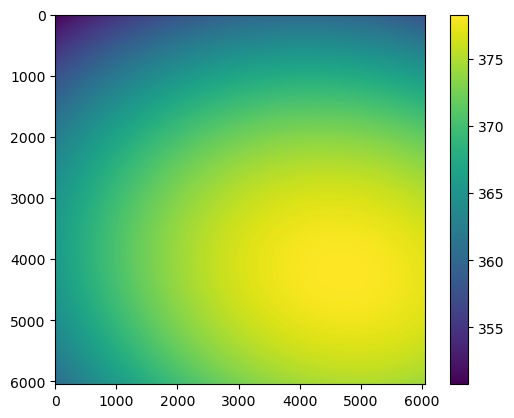

In [132]:
plt.imshow(octo_bg)
plt.colorbar()

In [138]:
rfp_t0

array([[  0,   0,   0, ...,   0,   0,   0],
       [313, 303, 304, ..., 296, 301,   0],
       [314, 316, 309, ..., 317, 311,   0],
       ...,
       [332, 337, 328, ..., 323, 315,   0],
       [335, 342, 318, ..., 325, 320,   0],
       [334, 333, 299, ..., 312, 322,   0]], dtype=uint64)

In [139]:
viewer.add_image((rfp_t0.astype(np.uint16) - octo_bg.astype(np.uint16))# contrast_limits=(0, 65000 ))

<Image layer 'Image [2]' at 0x7fee92ea4e50>

In [142]:
rfp_t0_octo_bgrm = utils.remove_background(rfp_t0).astype(np.uint16)

In [143]:
viewer.add_image(rfp_t0_octo_bgrm)

<Image layer 'rfp_t0_octo_bgrm' at 0x7fee7d80cd00>

# Checking new tracks for infected label properties

In [150]:
row, column = 3, 5

In [13]:
with btrack.io.HDF5FileHandler(os.path.join(base_dir, f'labels/relocalisation/infect_label_{row, column}.h5'), 
                                       'r', 
                                       obj_type='obj_type_1'
                                       ) as reader:
        tracks_labeld = reader.tracks    
#         segmentation = reader.segmentation
napari_tracks_labeld, properties, graph = btrack.utils.tracks_to_napari(tracks, ndim=2)

[INFO][2023/05/05 08:56:33 AM] Opening HDF file: /mnt/DATA/macrohet/labels/relocalisation/infect_label_(3, 5).h5...
[INFO][2023/05/05 08:56:33 AM] Loading tracks/obj_type_1
[INFO][2023/05/05 08:56:33 AM] Loading LBEP/obj_type_1
[INFO][2023/05/05 08:56:33 AM] Loading objects/obj_type_1 (28787, 5) (28787 filtered: None)
[INFO][2023/05/05 08:56:33 AM] Closing HDF file: /mnt/DATA/macrohet/labels/relocalisation/infect_label_(3, 5).h5


NameError: name 'tracks' is not defined

In [152]:
tracks_labeld[0]

,ID,t,x,y,z,parent,root,state,generation,dummy,Infected,mean_intensity,major_axis_length,area,orientation,minor_axis_length
0,317,0,1067.368652,55.120907,0.000000,317,317,5,0,False,1.0,"(3,) array",367.548309,79792.0,0.543640,297.442078
1,317,1,1076.627319,53.511284,0.000000,317,317,5,0,False,1.0,"(3,) array",343.924652,59611.0,0.830746,233.694473
2,317,2,1086.090088,46.542519,0.000000,317,317,5,0,False,1.0,"(3,) array",321.399139,60298.0,1.330036,241.751312
3,317,3,1067.435425,41.517868,0.000000,317,317,5,0,False,1.0,"(3,) array",339.685303,59265.0,1.387981,224.850403
4,317,4,1049.771729,38.330784,0.000000,317,317,5,0,False,1.0,"(3,) array",411.977295,63411.0,1.566783,203.218185
5,317,5,1050.415771,41.688465,0.000000,317,317,5,0,False,1.0,"(3,) array",543.717041,89396.0,-1.518311,222.127838
6,317,6,1034.244141,41.081558,0.000000,317,317,5,0,False,1.0,"(3,) array",449.364075,67568.0,-1.358899,200.842819
7,317,7,1025.088135,37.680584,-3.657916,317,317,5,0,True,NaN,"(3,) array",NaN,NaN,NaN,NaN
8,317,8,1032.142212,40.969135,0.000000,317,317,5,0,False,1.0,"(3,) array",464.707703,71756.0,-1.217776,211.361130
9,317,9,1060.545654,41.469288,0.000000,317,317,5,0,False,1.0,"(3,) array",647.624390,94893.0,-1.538676,207.644241


### Checking the mean intensity of thresholded image supplied

In [172]:
track = tracks_labeld[0]

In [178]:
infected_thresh_Mtb_int = [[track.properties['mean_intensity'][i][2] for i, t in enumerate(track.t) if track.properties['Infected'][i] == 1] for track in tracks_labeld]
uninfected_thresh_Mtb_int = [[track.properties['mean_intensity'][i][2] for i, t in enumerate(track.t) if track.properties['Infected'][i] != 1] for track in tracks_labeld]
   

In [183]:
infected_thresh_Mtb_int_t0 = [track.properties['mean_intensity'][0][2] for track in tracks_labeld if track.properties['Infected'][0] == 1]
uninfected_thresh_Mtb_int_t0 = [track.properties['mean_intensity'][0][2] for track in tracks_labeld if track.properties['Infected'][0] != 1]
   

In [179]:
import seaborn as sns

In [188]:
uninfected_thresh_Mtb_int_t0

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0

Text(0.5, 1.0, 'Mean infected thresholded intensity in t = 0')

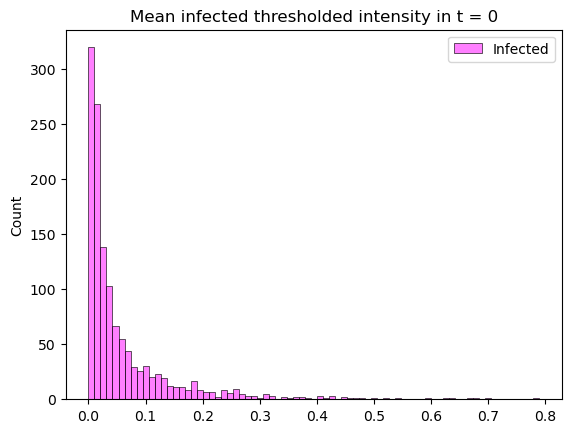

In [190]:
sns.histplot(data = infected_thresh_Mtb_int_t0, label = 'Infected', color = 'magenta', alpha = 0.5)
# sns.histplot(data = uninfected_thresh_Mtb_int_t0, label = 'Uninfected', color = 'green', alpha = 0.5)
plt.legend()
plt.title('Mean infected thresholded intensity in t = 0')

In [191]:
len(infected_thresh_Mtb_int_t0), len(uninfected_thresh_Mtb_int_t0)

(1298, 855)

## Check RFP signal in 'infected' cells

In [198]:
tracks_labeld[0]

,ID,t,x,y,z,parent,root,state,generation,dummy,Infected,mean_intensity,major_axis_length,area,orientation,minor_axis_length
0,317,0,1067.368652,55.120907,0.000000,317,317,5,0,False,1.0,"(3,) array",367.548309,79792.0,0.543640,297.442078
1,317,1,1076.627319,53.511284,0.000000,317,317,5,0,False,1.0,"(3,) array",343.924652,59611.0,0.830746,233.694473
2,317,2,1086.090088,46.542519,0.000000,317,317,5,0,False,1.0,"(3,) array",321.399139,60298.0,1.330036,241.751312
3,317,3,1067.435425,41.517868,0.000000,317,317,5,0,False,1.0,"(3,) array",339.685303,59265.0,1.387981,224.850403
4,317,4,1049.771729,38.330784,0.000000,317,317,5,0,False,1.0,"(3,) array",411.977295,63411.0,1.566783,203.218185
5,317,5,1050.415771,41.688465,0.000000,317,317,5,0,False,1.0,"(3,) array",543.717041,89396.0,-1.518311,222.127838
6,317,6,1034.244141,41.081558,0.000000,317,317,5,0,False,1.0,"(3,) array",449.364075,67568.0,-1.358899,200.842819
7,317,7,1025.088135,37.680584,-3.657916,317,317,5,0,True,NaN,"(3,) array",NaN,NaN,NaN,NaN
8,317,8,1032.142212,40.969135,0.000000,317,317,5,0,False,1.0,"(3,) array",464.707703,71756.0,-1.217776,211.361130
9,317,9,1060.545654,41.469288,0.000000,317,317,5,0,False,1.0,"(3,) array",647.624390,94893.0,-1.538676,207.644241


In [280]:
import importlib
importlib.reload(btrack)

<module 'btrack' from '/home/dayn/analysis/btrack/btrack/__init__.py'>

In [205]:
infected_segmentation = btrack.utils.update_segmentation(segmentation, tracks_labeld, scale = (5.04, 5.04), color_by="Infected")

In [207]:
v = napari.Viewer()

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


In [209]:
v.add_image(images[0,0,...], name = 'gfp', colormap= 'green')
v.add_image(rfp_t0, name = 'rfp', colormap = 'magenta')
v.add_labels(infected_segmentation)


<Tracks layer 'napari_tracks_labeld' at 0x7fea340633d0>

In [210]:
v.add_tracks(napari_tracks_labeld, scale = (5.04, 5.04))

<Tracks layer 'napari_tracks_labeld [1]' at 0x7fea22a5d7c0>

# Quantifying the number of infected cells

In [214]:
tracks_t0 = [track for track in tracks_labeld if track.in_frame(0)]
N_cell_t0 = len(tracks_t0)

In [220]:
infect_tracks_t0 = [track for track in tracks_t0 if track.properties['Infected'][0] == 1]
uninfect_tracks_t0 = [track for track in tracks_t0 if track.properties['Infected'][0] != 1]
N_cell_infect_t0 = len(infect_tracks_t0)
N_cell_uninfect_t0 = len(uninfect_tracks_t0)
print('N infected, N uninfected, Total')
print(N_cell_infect_t0, N_cell_uninfect_t0, N_cell_infect_t0+N_cell_uninfect_t0)

N infected, N uninfected, Total
282 200 482


In [237]:
track = [track for track in tracks_labeld if track.ID == 542][0]

In [241]:
t = 8

In [238]:
track

,ID,t,x,y,z,parent,root,state,generation,dummy,Infected,mean_intensity,major_axis_length,area,orientation,minor_axis_length
0,542,1,228.809723,117.090134,0.000000,542,542,5,0,False,0.0,"(3,) array",193.747253,15834.0,1.465492,105.098328
1,542,2,228.809723,117.090134,0.000000,542,542,5,0,True,NaN,"(3,) array",NaN,NaN,NaN,NaN
2,542,3,228.809723,117.090134,0.000000,542,542,5,0,True,NaN,"(3,) array",NaN,NaN,NaN,NaN
3,542,4,228.809723,117.090134,0.000000,542,542,5,0,True,NaN,"(3,) array",NaN,NaN,NaN,NaN
4,542,5,233.136810,136.536743,0.000000,542,542,5,0,False,1.0,"(3,) array",165.475006,14378.0,1.350825,111.301224
5,542,6,238.306259,153.045822,1.924129,542,542,5,0,True,NaN,"(3,) array",NaN,NaN,NaN,NaN
6,542,7,243.475693,169.554901,3.848259,542,542,5,0,True,NaN,"(3,) array",NaN,NaN,NaN,NaN
7,542,8,248.645142,186.063980,5.772388,542,542,5,0,True,NaN,"(3,) array",NaN,NaN,NaN,NaN
8,542,9,253.695755,189.457062,0.000000,542,542,5,0,False,1.0,"(3,) array",397.669556,55920.0,1.428451,184.277863


In [246]:
track.t.index(t)

7

In [243]:
track.properties['Infected'][]

array([ 0., nan, nan, nan,  1., nan, nan, nan,  1.])

In [242]:
track.properties['Infected'][t]

1.0

In [248]:
from tqdm.auto import tqdm

In [290]:
N_cell_infect = list()
N_cell_uninfect = list()

for t in tqdm(range(0, 75)):
    tracks_in_frame = [track for track in tracks_labeld if t in track.t]
    infect_tracks_ti = [track for track in tracks_in_frame 
                                if track.properties['Infected'][track.t.index(t)] == 1]
    uninfect_tracks_ti = [track for track in tracks_in_frame 
                                  if track.properties['Infected'][[track.t.index(t)]] != 1]
    N_cell_infect.append(len(infect_tracks_ti))
    N_cell_uninfect.append(len(uninfect_tracks_ti))


  0%|          | 0/75 [00:00<?, ?it/s]

<AxesSubplot:>

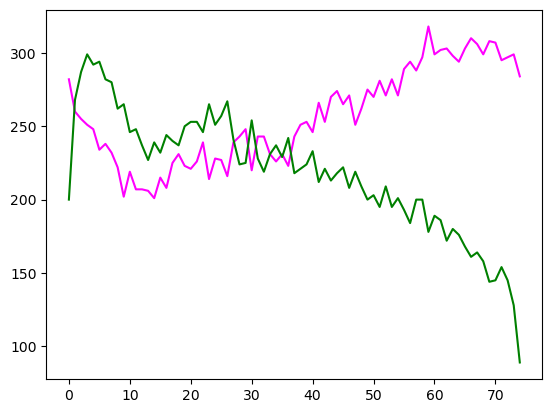

In [294]:
sns.lineplot(data = N_cell_infect, color = 'magenta')
sns.lineplot(data = N_cell_uninfect, color = 'green')

# Quantifying the number of infected cells in HQ tracks

In [295]:
tracks_hq = [track for track in tracks_labeld if len(track) >34]
len(tracks_hq)

344

<AxesSubplot:ylabel='Count'>

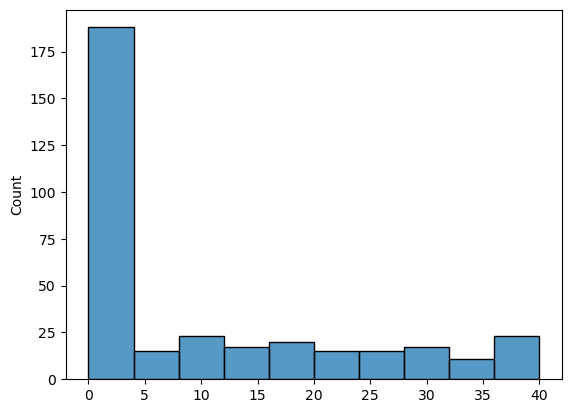

In [296]:
t0s_hq_tracks = [track.t[0] for track in tracks_hq]
sns.histplot(t0s_hq_tracks)

In [299]:
infect_tracks_hq = [track for track in tracks_hq if track.properties['Infected'][0] == 1]
uninfect_tracks_hq = [track for track in tracks_hq if track.properties['Infected'][0] != 1]
N_cell_infect_hq = len(infect_tracks_hq)
N_cell_uninfect_hq = len(uninfect_tracks_hq)
print('N infected, N uninfected, ')
print(N_cell_infect_hq, N_cell_uninfect_hq,)

N infected, N uninfected, 
208 136


In [303]:
N_cell_infect = list()
N_cell_uninfect = list()
N_cell = list()
for t in tqdm(range(0, 75)):
    tracks_in_frame = [track for track in tracks_hq if t in track.t]
    infect_tracks_ti = [track for track in tracks_in_frame 
                                if track.properties['Infected'][track.t.index(t)] == 1]
    uninfect_tracks_ti = [track for track in tracks_in_frame 
                                  if track.properties['Infected'][[track.t.index(t)]] != 1]
    N_cell.append(len(tracks_in_frame))
    N_cell_infect.append(len(infect_tracks_ti))
    N_cell_uninfect.append(len(uninfect_tracks_ti))


  0%|          | 0/75 [00:00<?, ?it/s]

<AxesSubplot:>

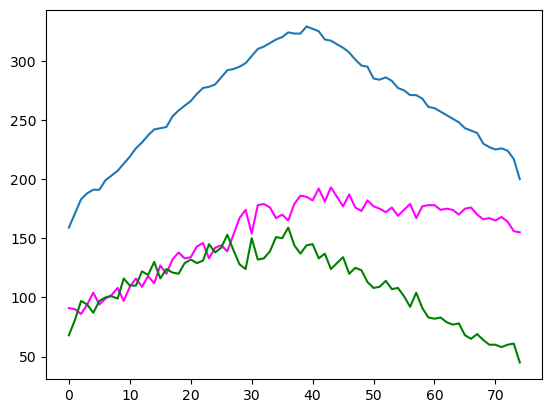

In [306]:
sns.lineplot(data = N_cell_infect, color = 'magenta')
sns.lineplot(data = N_cell_uninfect, color = 'green')
sns.lineplot(data = N_cell)

# Qualitative assessment of Mtb threshold

In [307]:
image_dir = os.path.join(base_dir, 'macrohet_images/Images_8bit')
images = tile.compile_mosaic(image_dir, 
                             metadata, 
                             row, column, 
                             set_plane='sum_proj',
#                              set_channel=1,
#                              set_time = 0,
#                             input_transforms = [input_transforms]
                            ).compute().compute()

In [309]:
v.add_image(images, 
            channel_axis=1,
            name=["macrophage", "mtb"],
            colormap=["green",  "magenta"],
            contrast_limits=[[0,6000], [0,1000]], 
            visible = True
            )

[<Image layer 'macrophage' at 0x7fea14fdf670>,
 <Image layer 'mtb' at 0x7fea150eb820>]

In [30]:
[track for track in tracks_labeld if track.ID == 328][0].properties['mean_intensity'][:,0]

array([[2.02174084e+03, 3.71504059e+02, 3.87256872e-03],
       [1.92346191e+03, 3.68779358e+02, 4.24418319e-03],
       [1.99290759e+03, 3.68193665e+02, 3.79780424e-03],
       [1.94635071e+03, 3.68823120e+02, 4.62330226e-03],
       [1.89501770e+03, 3.70074921e+02, 5.14106406e-03],
       [1.58790881e+03, 3.67157013e+02, 3.36704100e-03],
       [1.75961328e+03, 3.71151886e+02, 4.11437359e-03],
       [           nan,            nan,            nan],
       [1.89981775e+03, 3.71170624e+02, 4.59891837e-03],
       [1.54898132e+03, 3.66606842e+02, 3.37221916e-03],
       [1.61689905e+03, 3.65967773e+02, 3.86342523e-03],
       [1.72859436e+03, 3.65997986e+02, 4.74895258e-03]])

<AxesSubplot:>

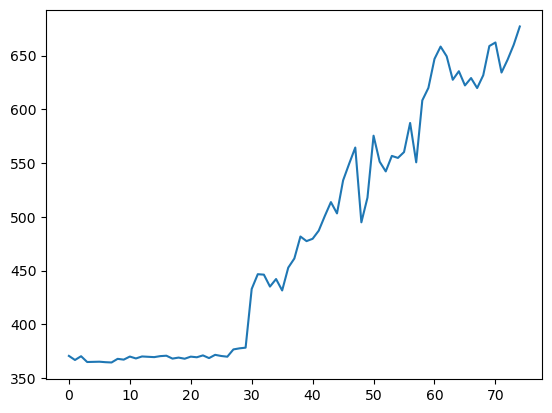

In [36]:
sns.lineplot(data = [track for track in tracks_labeld if track.ID == 328][0].properties['mean_intensity'][:,1])


<AxesSubplot:>

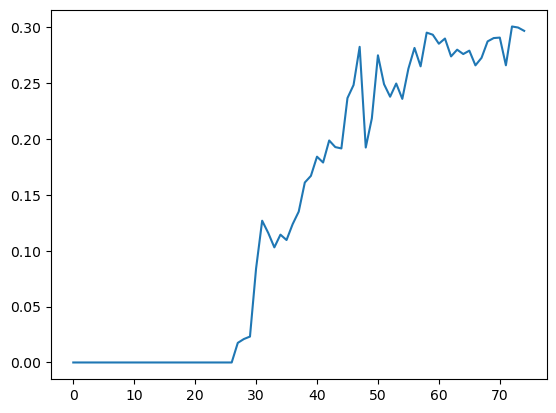

In [35]:
sns.lineplot(data = [track for track in tracks_labeld if track.ID == 328][0].properties['mean_intensity'][:,2])

In [38]:
[track for track in tracks_labeld if track.ID == 328][0]

,ID,t,x,y,z,parent,root,state,generation,dummy,Infected,orientation,minor_axis_length,major_axis_length,mean_intensity,area
0,328,0,1008.717163,13.787997,0.000000,328,328,5,0,False,0.0,-1.102150,141.621078,149.536469,"(3,) array",16539.0
1,328,1,1017.692261,13.876625,0.000000,328,328,5,0,False,0.0,-1.256759,142.007202,196.979034,"(3,) array",21793.0
2,328,2,1010.612000,22.133427,0.000000,328,328,5,0,False,0.0,-0.462099,142.950394,276.891296,"(3,) array",30076.0
3,328,3,1017.980957,17.815887,0.000000,328,328,5,0,False,0.0,-1.441019,212.037720,243.356888,"(3,) array",38735.0
4,328,4,1019.862122,18.439526,0.499649,328,328,5,0,True,NaN,NaN,NaN,NaN,"(3,) array",NaN
5,328,5,1006.563110,22.374271,0.000000,328,328,5,0,False,0.0,-0.895362,154.405670,332.633209,"(3,) array",37566.0
6,328,6,1012.670837,17.110456,0.000000,328,328,5,0,False,0.0,-1.052552,156.044601,270.035767,"(3,) array",31098.0
7,328,7,1009.820618,17.756680,0.000000,328,328,5,0,False,0.0,-0.867934,149.516876,276.280579,"(3,) array",29739.0
8,328,8,997.229980,29.168005,0.000000,328,328,5,0,False,0.0,-0.761950,135.809814,409.355835,"(3,) array",41511.0
9,328,9,1004.470764,24.274359,0.000000,328,328,5,0,False,0.0,-0.733477,167.457626,321.869781,"(3,) array",38268.0


In [41]:
row, column

(3, 5)